# Quantify the confidence of the anomaly detection score

While anomaly scores indicate whether adata point is anomalous or normal, they do not indicate how confident the anomaly detector is about its predictions. Nevertheless, it would be interesting to know exactly how confident the models are. In `dtaianomaly`, each `TimeSeriesAnomalyDetector` has a method `predict_confidence(np.ndarray)` which does exactly this [1]! In this notebook, we briefly show how the confidence works and how it should be interpreted. 

[1] Perini, Lorenzo, Vincent Vercruyssen, and Jesse Davis. "Quantifying the confidence of anomaly detectors in their example-wise predictions." Joint European Conference on Machine Learning and Knowledge Discovery in Databases. Cham: Springer International Publishing, 2020. [DOI: 10.1007/978-3-030-67664-3_14](https://doi.org/10.1007/978-3-030-67664-3_14)

In [1]:
from dtaianomaly.anomaly_detection import PyODAnomalyDetector, Windowing
from dtaianomaly.visualization import plot_data, plot_anomaly_scores
from dtaianomaly.data_management.DataManager import DataManager

In [2]:
# A function to format the figures generated in this notebook. 
def format_figure(figure, title):
    figure.set_size_inches(12, 3)
    figure.axes[0].set_xlabel('Time', fontsize=14)
    figure.suptitle(title, fontsize=16)
    figure.tight_layout()

First we load a simple synthetic dataset: a sine wave with (minor) Gaussian noise, and one anomaly near the end. 

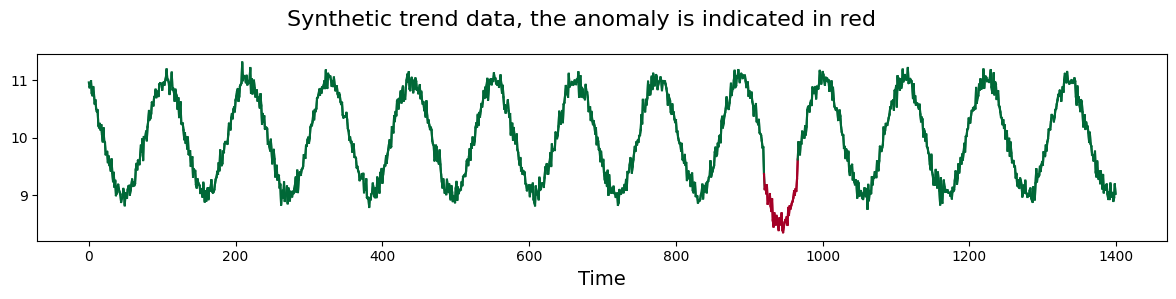

In [3]:
data_manager = DataManager('../data/datasets.csv')
data_manager.select({'collection_name': 'Demo'})
dataset_index = data_manager.get(0)
trend_data_df = data_manager.load(dataset_index)
trend_data, ground_truth = data_manager.load_raw_data(dataset_index)
fig = plot_data(trend_data_df, show_ground_truth='overlay')
format_figure(fig, 'Synthetic trend data, the anomaly is indicated in red')

Before we can compute the confidence of an anomaly detector, we must train an anomaly detector. Here we use an Isolation Forest, which assigns an anomaly score to every window of 32 data points. We can see that the anomaly has been correctly identified. 

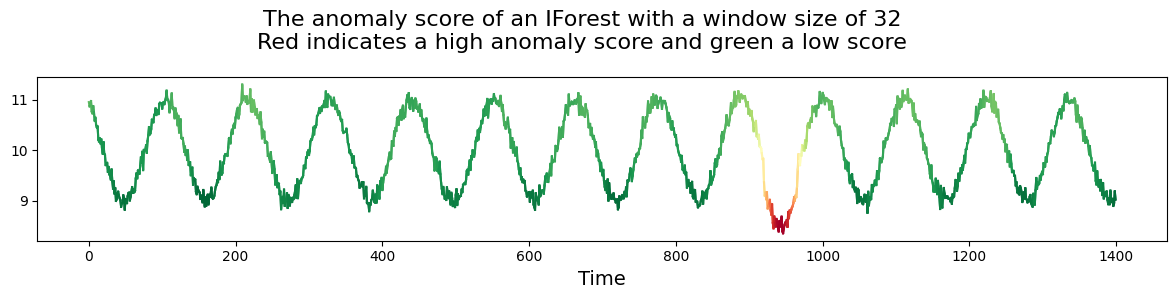

In [4]:
anomaly_detector = PyODAnomalyDetector('IForest', Windowing(32))
anomaly_detector.fit(trend_data)
fig = plot_anomaly_scores(
    trend_data=trend_data_df,
    anomaly_scores=anomaly_detector.decision_function(trend_data),
    show_anomaly_scores='overlay',
    show_ground_truth=None
)
format_figure(fig, 'The anomaly score of an IForest with a window size of 32\n'
              'Red indicates a high anomaly score and green a low score')

Now we can quantify the confidence score of the anomaly detector. First of all, notice that a warning is being thrown. This is because the data is assumed to be i.i.d., which is not the case for an Isolation Forest that computes an anomaly score over sliding windows. Nevertheless, we can interpret the confidence score. In general, the model is very confident over the entire time domain, except just before and just after the anomaly. Right in the center of the anomaly, however, the model is certain about its decision: the interval is anomalous. These results make sense, because it is difficult for the model to predict the exact border of the anomaly (uncertain around the edges of the anomaly), but it knows that an anomaly is located in that interval (certain at the center of the anomaly). 

C:\Users\louis\PycharmProjects\dtaianomaly\dtaianomaly\anomaly_detection\pyod\PyODAnomalyDetector.py:53: UserWarning: To compute the confidence of an anomaly detector, the train data should be i.i.d., which is not the case for a PyOD anomaly detector that predicts anomaly scores for a sliding window.
  warnings.warn('To compute the confidence of an anomaly detector, the train data should be i.i.d., '


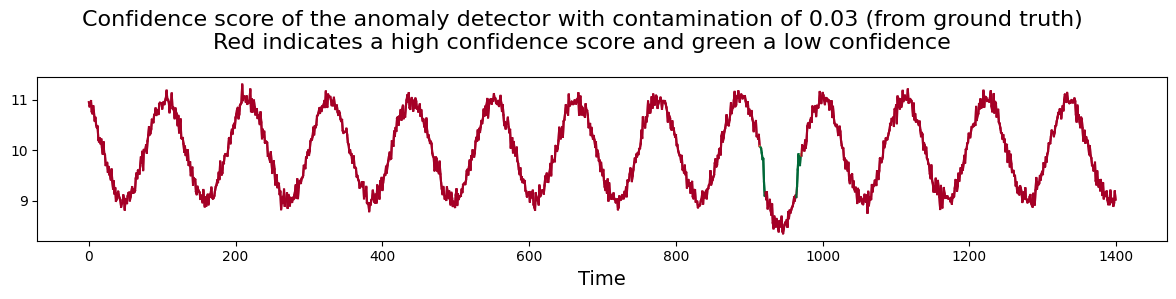

In [5]:
fig = plot_anomaly_scores(
    trend_data=trend_data_df,
    anomaly_scores=anomaly_detector.predict_confidence(trend_data, 0.03),
    show_anomaly_scores='overlay',
    show_ground_truth=None
)
format_figure(fig, 'Confidence score of the anomaly detector with contamination of 0.03 (from ground truth)\n'
              'Red indicates a high confidence score and green a low confidence')